This dataset has over 300k records.
BMI
Underweight	Below 18.5
Normal	18.5–24.9
Overweight	25.0–29.9
Obesity	30.0 and A
The data was cleaned to remove outliersbove

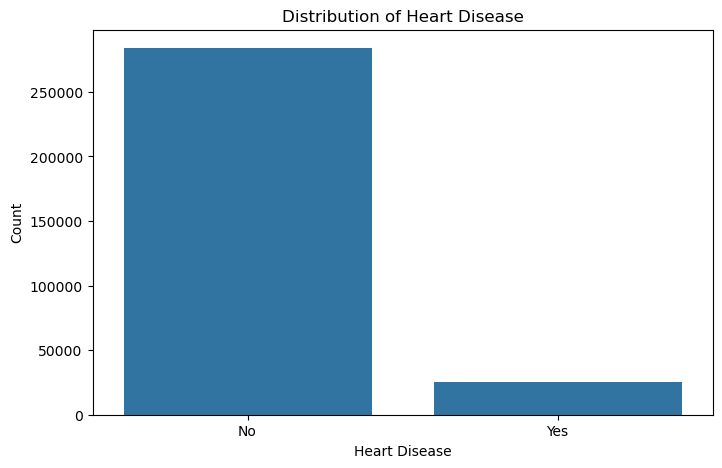


Number of records before cleaning: 308854
Number of records after cleaning: 308288


In [93]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd

cvd_cleaned_df = pd.read_csv('CVD_cleaned.csv')

# Count plot
plt.figure(figsize=(8, 5))
sb.countplot(data=cvd_cleaned_df, x='Heart_Disease')
plt.title('Distribution of Heart Disease')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.show()

data = pd.read_csv('CVD_cleaned.csv')
# Clean the data
data = data[(data['Height_(cm)'] >= 100) & (data['Height_(cm)'] <= 250)]
data = data[(data['Weight_(kg)'] >= 20) & (data['Weight_(kg)'] <= 300)]
data = data[(data['BMI'] >= 10) & (data['BMI'] <= 60)]

# Check how many rows were removed
print(f"\nNumber of records before cleaning: {len(cvd_cleaned_df)}")
print(f"Number of records after cleaning: {len(data)}")



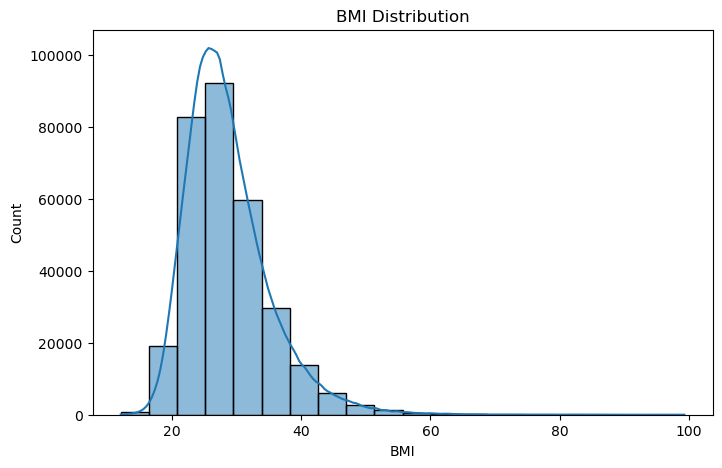

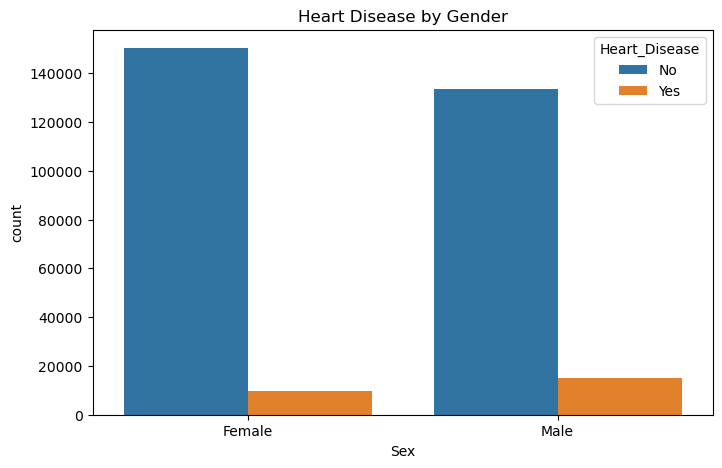

In [94]:
# Histogram for BMI
plt.figure(figsize=(8, 5))
sb.histplot(cvd_cleaned_df['BMI'], kde=True, bins=20)
plt.title('BMI Distribution')
plt.show()

# Heart Disease by Gender
plt.figure(figsize=(8, 5))
sb.countplot(data=cvd_cleaned_df, x='Sex', hue='Heart_Disease')
plt.title('Heart Disease by Gender')
plt.show()

In [ ]:
from pyspark.sql import SparkSession

# Initialise Spark session
spark = SparkSession.builder.appName("CVD_ML_Project").getOrCreate()

# Load the data into Spark DataFrame
# cvd_spark_df = spark.read.csv('CVD_cleaned.csv', header=True, inferSchema=True)

# Load into HDFS
cvd_spark_df = spark.read.csv('hdfs://namenode:8020/data/cvd/CVD_cleaned.csv', header=True, inferSchema=True)

Building Logistic Regression model using PySpark for predicting Heart Disease. It involves data preprocessing, feature engineering, model training, and evaluation using PySpark MLlib. 

In [11]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix

categoricalColumns = ['General_Health', 'Sex', 'Smoking_History', 'Age_Category']
stages = []

# StringIndexer and OneHotEncoder for each categorical column to turn it into numerical
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

# convert heart disease values to 1 or 0
label_stringIdx = StringIndexer(inputCol='Heart_Disease', outputCol='label')
stages += [label_stringIdx]

numericCols = ['BMI', 'Height_(cm)', 'Weight_(kg)']  

# vectorAssembler: combine categorical and numeric columns into a single feature vector
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# pipeline for the transformations, ensure transfomations are applied sequentially
pipeline = Pipeline(stages=stages)

# fit and transform
cvd_transformed = pipeline.fit(cvd_spark_df).transform(cvd_spark_df)
# train test split
train, test = cvd_transformed.randomSplit([0.75, 0.25], seed=12345)

# train logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train)

predictions = lr_model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol='label')
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")



Test Accuracy: 0.8251534936153139


This model only has a 82% accuracy, with a high false negative rate, therefore, the model could be improved.

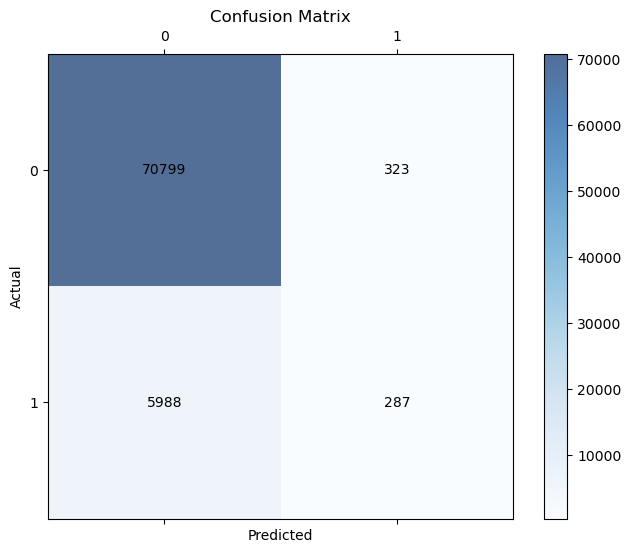

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

predictions_pd = predictions.select('Heart_Disease', 'prediction').toPandas()
conf_matrix = pd.crosstab(predictions_pd['Heart_Disease'], predictions_pd['prediction'], rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap='Blues', alpha=0.7, fignum=1)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix.iloc[i, j], ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()


BMI_Category
Obese          0.221536
Overweight     0.116733
normal         0.060205
underweight    0.049114
Name: Diabetes_numeric, dtype: float64


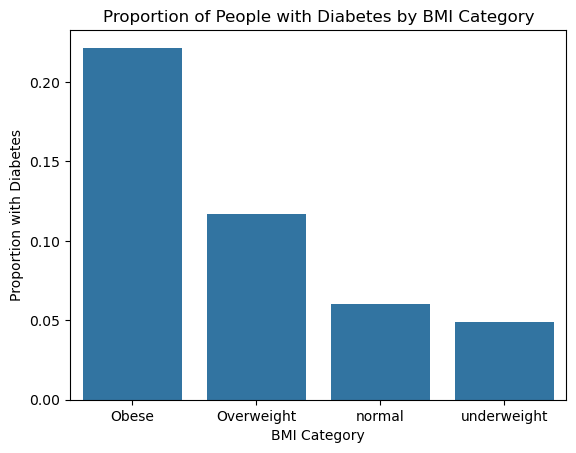

In [158]:
data = cvd_spark_df.select("BMI", "Diabetes").toPandas()

def map_diabetes_status(diabetes_status):
    if diabetes_status == 'No':
        return 0  
    elif diabetes_status == 'Yes':
        return 1  
    else:
        return None  

data['Diabetes_numeric'] = data['Diabetes'].apply(map_diabetes_status)
data = data.dropna(subset=['Diabetes_numeric'])

def categorise_bmi(bmi):
    if bmi < 18.5:
        return "underweight"
    elif 18.5 <= bmi < 25:
        return "normal"
    elif 25 <= bmi < 30:
        return "Overweight"
    else:
        return "Obese"

data['BMI_Category'] = data['BMI'].apply(categorise_bmi)

# Calculate the proportion of people with diabetes in each BMI category
diabetes_by_bmi = data.groupby('BMI_Category')['Diabetes_numeric'].mean()
print(diabetes_by_bmi)

sb.barplot(x=diabetes_by_bmi.index, y=diabetes_by_bmi.values)
plt.title("Proportion of People with Diabetes by BMI Category")
plt.ylabel("Proportion with Diabetes")
plt.xlabel("BMI Category")
plt.show()



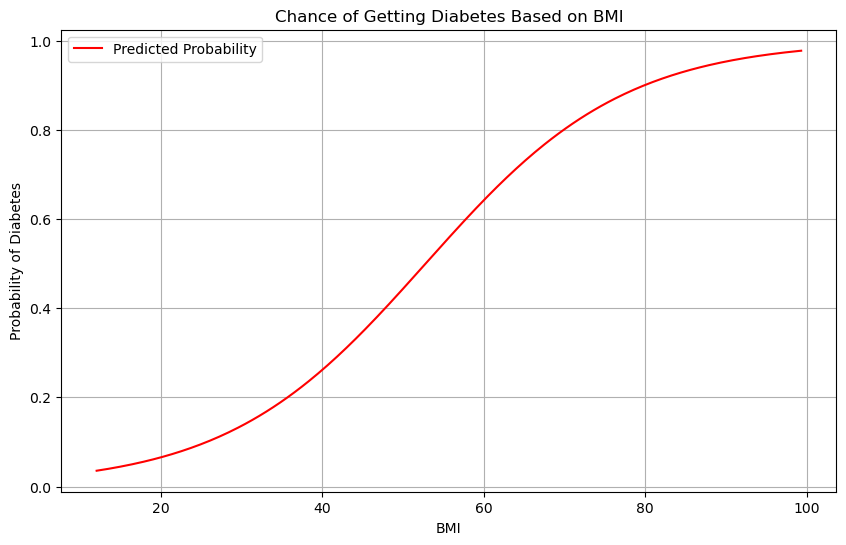

In [118]:
X = data[['BMI']].values  # Predictor (BMI)
y = data['Diabetes_numeric'].values  # Target (Diabetes: 0 or 1)

logreg = LogisticRegression()
logreg.fit(X, y)

bmi_range = np.linspace(data['BMI'].min(), data['BMI'].max(), 300).reshape(-1, 1)

# Predict the probability of diabetes for each BMI value
diabetes_prob = logreg.predict_proba(bmi_range)[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(bmi_range, diabetes_prob, color='red', label='Predicted Probability')
plt.title('Chance of Getting Diabetes Based on BMI')
plt.xlabel('BMI')
plt.ylabel('Probability of Diabetes')
plt.grid(True)
plt.legend()
plt.show()

People with no heart diseases, consumed more fruits and vegetables.
For fried potato consumption, the result was very similar.
However people that consumed alcohol has more people 

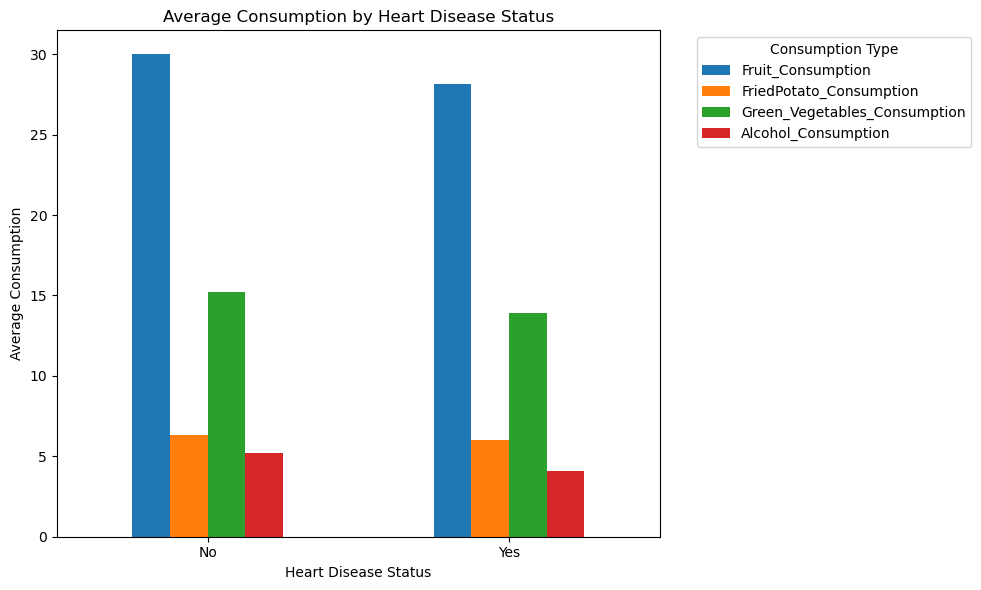

In [122]:
# Calculate the mean consumption for each food category
mean_fruit_consumption = cvd_cleaned_df.groupby('Heart_Disease')['Fruit_Consumption'].mean()
mean_green_vegetables = cvd_cleaned_df.groupby('Heart_Disease')['Green_Vegetables_Consumption'].mean()
mean_fried_potato = cvd_cleaned_df.groupby('Heart_Disease')['FriedPotato_Consumption'].mean()
mean_alcohol_consumption = cvd_cleaned_df.groupby('Heart_Disease')['Alcohol_Consumption'].mean()

mean_consumption_df = pd.DataFrame({
    'Fruit_Consumption': mean_fruit_consumption,
    'FriedPotato_Consumption': mean_fried_potato,
    'Green_Vegetables_Consumption': mean_green_vegetables,
    'Alcohol_Consumption': mean_alcohol_consumption
})

mean_consumption_df.plot(kind='bar', figsize=(10, 6))
plt.title('Average Consumption by Heart Disease Status')
plt.ylabel('Average Consumption')
plt.xlabel('Heart Disease Status')
plt.xticks(rotation=0)
plt.legend(title='Consumption Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


ROC (Receiver Operating Characteristic) Curve shows the trade-off between the true positive rate and false positive rate at various threshold settings.

Area Under the Curve (AUC):
The AUC value here is approximately 0.827, which measures the overall ability of the model to distinguish between the positive class (presence of heart disease) and the negative class.
AUC values range from 0 to 1:
0.5: The model performs no better than random guessing.
0.7 - 0.8: Indicates a fair model.
0.8 - 0.9: Indicates a good model.
greater than 0.9: Indicates an execllent model.

This model performs well, it performs much better than if it was 50/50 guessing. Ideal curve would go straight up and right.

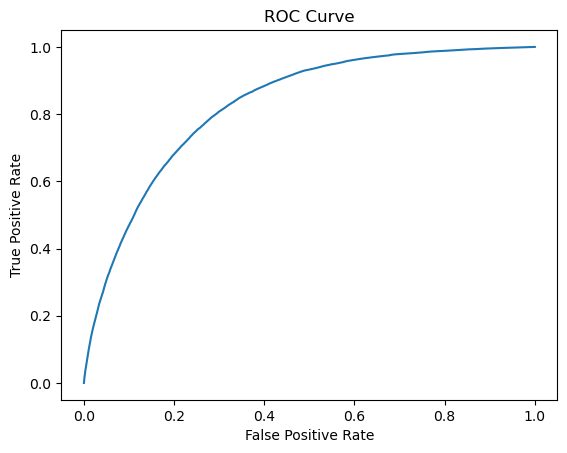

Training set areaUnderROC: 0.8273769713552981


In [156]:
trainingSummary = lr_model.summary
roc = trainingSummary.roc.toPandas()

# ROC curve
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the Area Under the ROC Curve (AUC)
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))



Model: Random forest Classifier. Undersampled for better results.

In [144]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

# balance the data for nos and yes'
majority_class = train.filter(col('label') == 0.0)
minority_class = train.filter(col('label') == 1.0)

# the sample method randomly selects a subset of the majority class to match with minority 
undersampled_majority_class = majority_class.sample(
    withReplacement=False, 
    fraction=minority_class.count() / majority_class.count()
)
balanced_train = minority_class.unionAll(undersampled_majority_class)

rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=100, maxDepth=10)

rfModel = rf.fit(balanced_train)
predictions_rf = rfModel.transform(test)
predictions_rf.select('BMI', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

# Evaluate the model using Area Under ROC
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')
roc_auc_rf = evaluator.evaluate(predictions_rf)
print(f"random forest: Test Area Under ROC: {roc_auc_rf}")


+-----+-----+--------------------+----------+--------------------+
|  BMI|label|       rawPrediction|prediction|         probability|
+-----+-----+--------------------+----------+--------------------+
|26.15|  0.0|[89.2030823840407...|       0.0|[0.89203082384040...|
|27.32|  0.0|[82.1634880742006...|       0.0|[0.82163488074200...|
|21.09|  0.0|[83.6630244342006...|       0.0|[0.83663024434200...|
|32.98|  0.0|[86.8560350824884...|       0.0|[0.86856035082488...|
|22.32|  0.0|[83.9748327843159...|       0.0|[0.83974832784315...|
|29.03|  0.0|[66.4763574858363...|       0.0|[0.66476357485836...|
|28.48|  0.0|[24.5385260090559...|       1.0|[0.24538526009055...|
|19.53|  0.0|[88.8980668675507...|       0.0|[0.88898066867550...|
|42.74|  0.0|[80.5367130870880...|       0.0|[0.80536713087088...|
|16.79|  0.0|[89.9056986838776...|       0.0|[0.89905698683877...|
+-----+-----+--------------------+----------+--------------------+
only showing top 10 rows

random forest: Test Area Under ROC: 

I believe that this model is better as it is better to have more false positive then a lot of false negatives (the first model). This is because it is better to be safe than to be sorry and patients should always be more careful with their bmi. If the model predicted that you will not have diabetes but in fact you are at risk, that is worse than predicting that you have diabetes but in fact you do not.

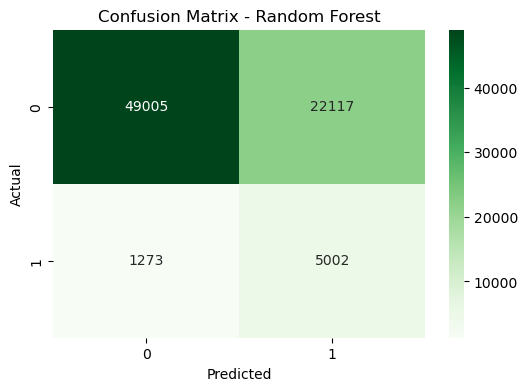

In [145]:
predictions_rf_pd = predictions_rf.select('label', 'prediction').toPandas()

conf_matrix_rf = confusion_matrix(predictions_rf_pd['label'], predictions_rf_pd['prediction'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', cbar=True)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
